In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn

In [3]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")
device = torch.device("cpu")

GPU: NVIDIA GeForce GTX 1650 Ti


In [4]:
class Euler_Model:
    def __init__(self, f, dx, device):
        self.f = f
        self.dx = dx
        self.device = device

    def step(self, inputs, k):
        x, y = inputs[0:1, :], inputs[1:2, :]
        y_next = y + self.dx * self.f(x, y, k)
        x_next = x + self.dx
        return torch.cat([x_next, y_next], axis = 0)

In [5]:
class RK4_Model:
    def __init__(self, f, dx, device):
        self.f = f
        self.dx = dx
        self.device = device

    def step(self, inputs, k):
        x, y = inputs[0:1, :], inputs[1:2, :]
        k1 = self.dx * self.f(x, y, k)
        k2 = self.dx * self.f(x + 0.5 * self.dx, y + 0.5 * k1, k)
        k3 = self.dx * self.f(x + 0.5 * self.dx, y + 0.5 * k2, k)
        k4 = self.dx * self.f(x + self.dx, y + k3, k)
        y_next = y + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        x_next = x + self.dx
        return torch.cat([x_next, y_next], axis = 0)

In [6]:
def generate_data(simulation, initial_state, steps, k_values):
  n_dataset = k_values.shape[1]
  data = torch.zeros(steps, 2, n_dataset)
  current_state = initial_state
  for i in range(steps):
    data[i, :] = current_state
    current_state = simulation.step(current_state, k_values)
  return data

In [7]:
# Define the differential equation function (you should replace this with your specific function)
def f(x, y, k):
    return (x- y) * k  # Example function


In [8]:
k_values = torch.tensor([[0.1, 1.0, 10.0]]).to(device)
n_dataset = k_values.shape[1]

In [9]:
initial_state = torch.zeros(2, n_dataset).to(device)
initial_state[1, :] = 1
step_size = 0.025

# Create the Euler simulation
euler_simulation = Euler_Model(f, step_size, device)

# Create the RK4 simulation
RK4_simulation = RK4_Model(f, step_size, device)

# Generate synthetic data for training and evaluation
training_steps = 40  # Adjust the number of steps as needed

euler_data = generate_data(euler_simulation, initial_state, steps=training_steps, k_values= k_values)
RK4_data = generate_data(RK4_simulation, initial_state, steps=training_steps, k_values=k_values)

euler_plot = euler_data.cpu().detach().numpy()
RK4_plot = RK4_data.cpu().detach().numpy()


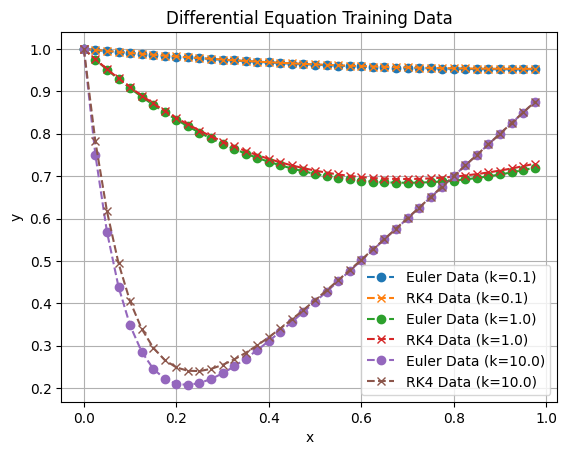

In [10]:
# Plot for each k value
for i in range(n_dataset):
    plt.plot(euler_plot[:, 0, i], euler_plot[:, 1, i], label=f'Euler Data (k={k_values[0, i]:.1f})', linestyle='--', marker='o')
    plt.plot(RK4_plot[:, 0, i], RK4_plot[:, 1, i], label=f'RK4 Data (k={k_values[0, i]:.1f})', linestyle='--', marker='x')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Differential Equation Training Data')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.output_size = output_size

        # Create a list to store the layers, including hidden layers
        layers = []

        # Add input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(activation)

        # Add hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(activation)

        # Add output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))

        # Define the neural network using Sequential
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [12]:
class DifferentialSolver:
    def __init__(self, model, optimizer, criterion = nn.MSELoss()):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    def train(self, simulation, target_solution, k_values, max_epochs=1000, msteps=2, batch_size= 100):
        losses = []
        N = len(target_solution)
        feasible_range = N - msteps - 1
        target_solution = torch.tensor(target_solution , dtype=torch.float32).to(device)

        for epoch in range(max_epochs):
            self.optimizer.zero_grad()
            loss = 0

            for i in range(batch_size):
                r = np.random.randint(feasible_range)
                current_state = target_solution[r, :]

                for m in range(msteps):
                    current_state = simulation.step(current_state, k_values)  # Perform a step using the provided method
                    network_input = torch.cat([current_state, k_values], axis = 0).to(device)
                    correction = self.model(network_input.T).T
                    current_state[1:2, :] += correction * (simulation.dx ** 2)
                    loss += self.criterion(current_state[1, :], target_solution[r + m + 1, 1, :])

            loss.backward(retain_graph = True)
            self.optimizer.step()

            if epoch % 100 == 0:
                print(epoch, "Training Loss:", loss.item())

            losses.append(loss.item())

        return losses

    def applyNN(self, current_state):

        Network_input = torch.tensor(current_state, dtype=torch.float32).to(device)
        correction = self.model(Network_input)

        return correction.cpu().detach().numpy()

In [13]:
# Create a neural network model
model = NeuralNet(3, [8, 16, 8], 1, nn.Sigmoid()).to(device)

# Create a DifferentialSolver and train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
solver = DifferentialSolver(model, optimizer)
losses = solver.train(euler_simulation, target_solution=RK4_data, k_values=k_values, max_epochs=2000, msteps=1, batch_size= 40)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14380\3286012083.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_solution = torch.tensor(target_solution , dtype=torch.float32).to(device)


0 Training Loss: 0.00036697470932267606
100 Training Loss: 3.405382085475139e-05
200 Training Loss: 9.643108933232725e-05
300 Training Loss: 9.673845852375962e-06
400 Training Loss: 3.1514412057731533e-06
500 Training Loss: 1.4959945247028372e-06
600 Training Loss: 1.4904200043019955e-06
700 Training Loss: 1.1453662409621757e-06
800 Training Loss: 1.2465624195101555e-06
900 Training Loss: 1.1982888281636406e-06
1000 Training Loss: 2.71723183686845e-06
1100 Training Loss: 1.4021815104570123e-06
1200 Training Loss: 3.308433952042833e-05
1300 Training Loss: 3.5281775581097463e-06
1400 Training Loss: 2.1531741367653012e-06
1500 Training Loss: 1.2328816865192493e-06
1600 Training Loss: 1.071114184014732e-06
1700 Training Loss: 1.1981104535152554e-06
1800 Training Loss: 1.202766156893631e-06
1900 Training Loss: 1.138252514465421e-06


In [14]:
class Differential_Euler_Model:
    def __init__(self, simulation, solver, device):
        self.simulation = simulation
        self.solver = solver
        self.device = device

    def step(self, inputs, k_values):
        current_state = self.simulation.step(inputs, k_values)  # Perform a step using the provided method
        network_input = torch.tensor(current_state).to(device)
        network_input = torch.cat([current_state, k_values], axis = 0).to(device)
        correction = solver.model(network_input.T).T
        current_state[1:2, :] += correction * (self.simulation.dx ** 2)
        return current_state

In [15]:
Differential_Euler_simulation = Differential_Euler_Model(euler_simulation, solver, device)
differential_euler_data = generate_data(Differential_Euler_simulation, initial_state, k_values=k_values, steps=training_steps)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14380\2050125787.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  network_input = torch.tensor(current_state).to(device)


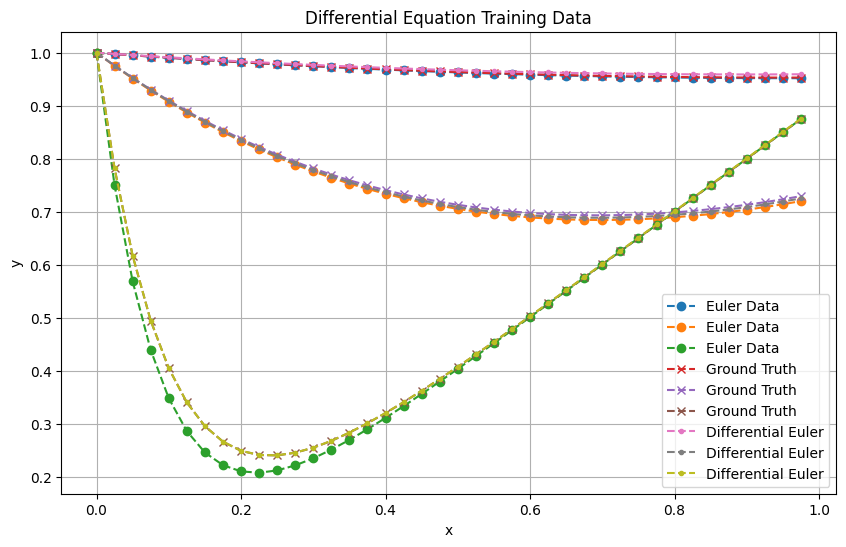

In [16]:
# Plot the training data
euler_with_NN_plot = differential_euler_data.cpu().detach().numpy()

plt.figure(figsize=(10, 6))
plt.plot(euler_plot[:, 0], euler_plot[:, 1], label='Euler Data', linestyle='--', marker='o')
plt.plot(RK4_data[:, 0], RK4_data[:, 1], label='Ground Truth', linestyle='--', marker='x')
plt.plot(euler_with_NN_plot[:, 0], euler_with_NN_plot[:, 1], label='Differential Euler', linestyle='--', marker='.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Differential Equation Training Data')
plt.legend()
plt.grid(True)
plt.show()

240


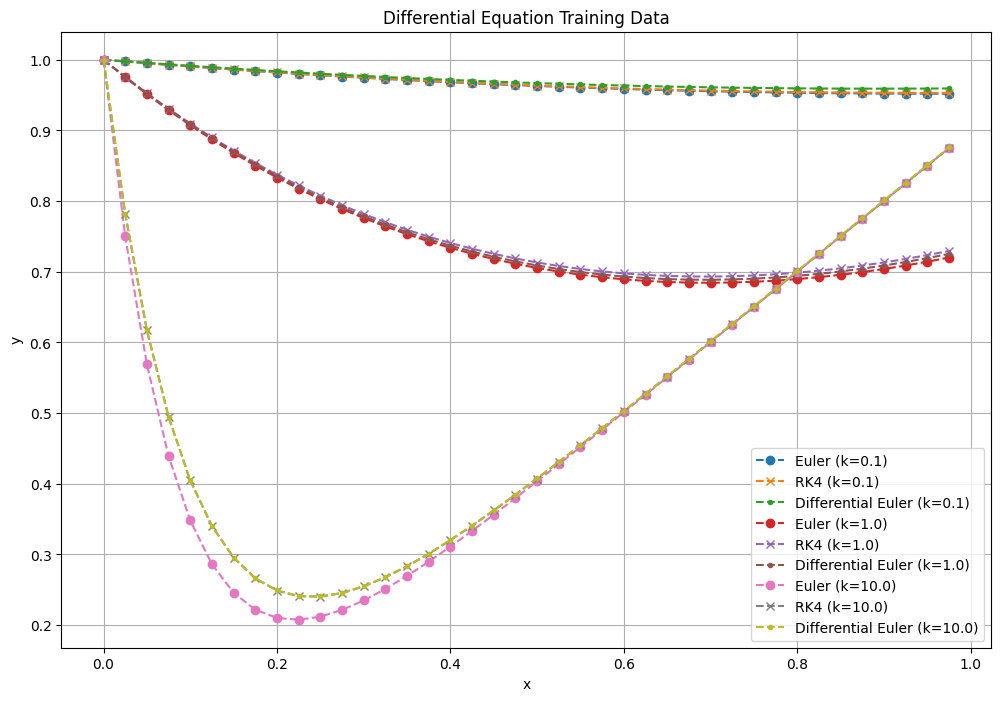

In [25]:
# Plot for each k value
print(euler_with_NN_plot.size)
plt.figure(figsize=(12, 8))
for i in range(n_dataset):
    plt.plot(euler_plot[:, 0, i], euler_plot[:, 1, i], label=f'Euler (k={k_values[0, i]:.1f})', linestyle='--', marker='o')
    plt.plot(RK4_plot[:, 0, i], RK4_plot[:, 1, i], label=f'RK4 (k={k_values[0, i]:.1f})', linestyle='--', marker='x')
    plt.plot(euler_with_NN_plot[:, 0,i], euler_with_NN_plot[:, 1,i], label=f'Differential Euler (k={k_values[0, i]:.1f})', linestyle='--', marker='.')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Differential Equation Training Data')
plt.legend()
plt.grid(True)
plt.show()

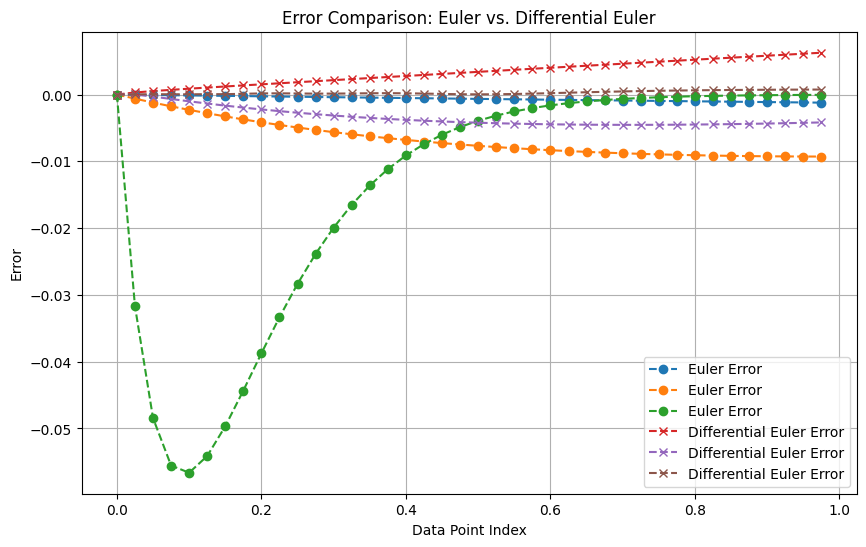

Euler L2 Loss: 0.0002022571279667318
Differential Euler L2 Loss: 9.195207894663326e-06


In [18]:
# Calculate the L2 loss for Euler and Differential Euler
deviation_euler = (euler_data - RK4_data)[:, 1].cpu().detach().numpy()
deviation_euler_differential = (differential_euler_data - RK4_data)[:, 1].cpu().detach().numpy()
euler_loss = np.mean((deviation_euler) ** 2)
differential_euler_loss = np.mean( deviation_euler_differential** 2)


plt.figure(figsize=(10, 6))
plt.plot(euler_plot[:, 0], deviation_euler, label='Euler Error', linestyle='--', marker='o')
plt.plot(euler_plot[:, 0], deviation_euler_differential, label='Differential Euler Error', linestyle='--', marker='x')
plt.xlabel('Data Point Index')
plt.ylabel('Error')
plt.title('Error Comparison: Euler vs. Differential Euler')
plt.legend()
plt.grid(True)
plt.show()

print(f'Euler L2 Loss: {euler_loss}')
print(f'Differential Euler L2 Loss: {differential_euler_loss}')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14380\2050125787.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  network_input = torch.tensor(current_state).to(device)


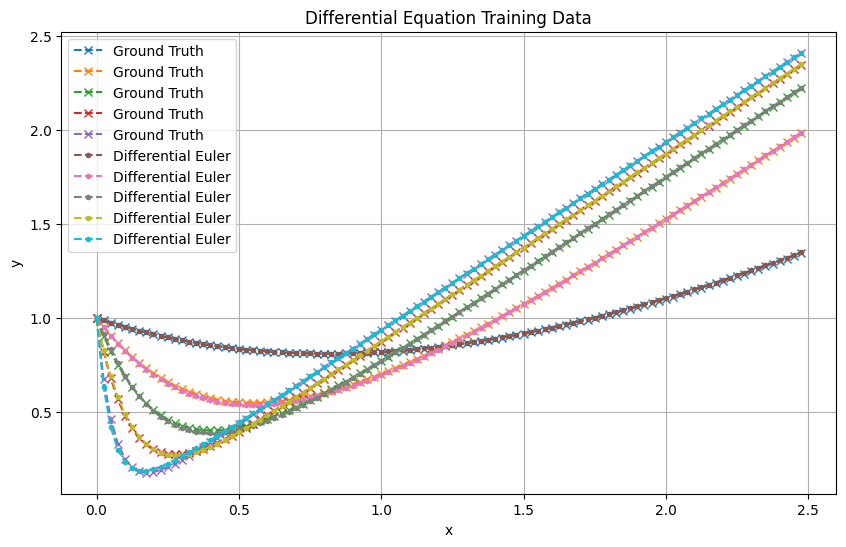

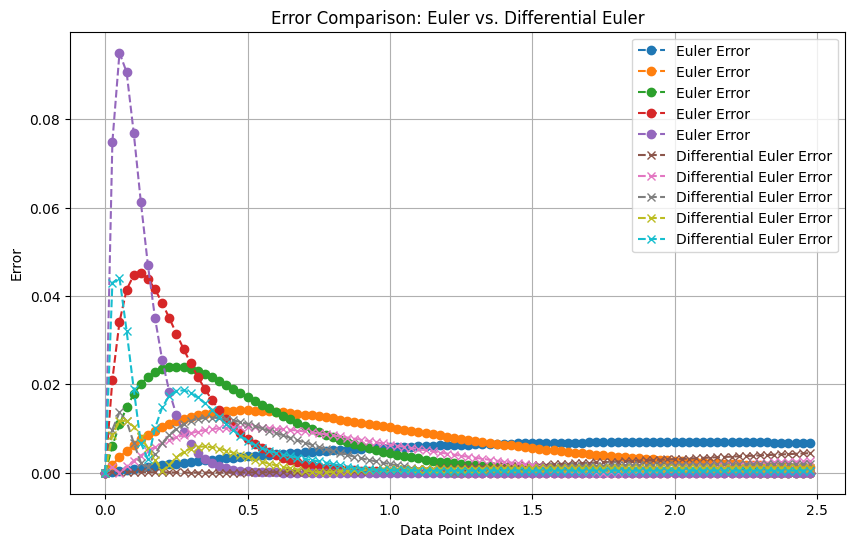

Euler L2 Loss: 0.00015204623923636973
Differential Euler L2 Loss: 3.176073732902296e-05


In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ... (the rest of your code remains the same)

# Generate synthetic data for training and evaluation
testing_steps = 100  # Adjust the number of steps as needed
k_values_test = torch.tensor([[0.5, 2, 4, 8, 16]]).to(device)
n_dataset_test = k_values_test.shape[1]
initial_state_test = torch.zeros(2, n_dataset_test).to(device)
initial_state_test[1, :] = 1

euler_data_test = generate_data(euler_simulation, initial_state_test, k_values= k_values_test,steps=testing_steps)
RK4_data_test = generate_data(RK4_simulation, initial_state_test, k_values= k_values_test ,steps=testing_steps)

# Plot the training data
euler_plot_test = euler_data_test.cpu().detach().numpy()
RK4_plot_test = RK4_data_test.cpu().detach().numpy()

differential_euler_data_test = generate_data(Differential_Euler_simulation, initial_state_test, k_values=k_values_test, steps=testing_steps)

# Plot the training data
euler_with_NN_plot_test = differential_euler_data_test.cpu().detach().numpy()

plt.figure(figsize=(10, 6))
# plt.plot(euler_plot_test[:, 0], euler_plot_test[:, 1], label='Euler Data', linestyle='--', marker='o')
plt.plot(RK4_plot_test[:, 0], RK4_plot_test[:, 1], label='Ground Truth', linestyle='--', marker='x')
plt.plot(euler_with_NN_plot_test[:, 0], euler_with_NN_plot_test[:, 1], label='Differential Euler', linestyle='--', marker='.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Differential Equation Training Data')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the L2 loss for Euler and Differential Euler
deviation_euler_test = np.abs((euler_data_test - RK4_data_test)[:, 1].cpu().detach().numpy())
deviation_euler_differential_test = np.abs((differential_euler_data_test - RK4_data_test)[:, 1].cpu().detach().numpy())
euler_loss_test = np.mean((deviation_euler_test) ** 2)
differential_euler_loss_test = np.mean(deviation_euler_differential_test ** 2)

plt.figure(figsize=(10, 6))
plt.plot(euler_plot_test[:, 0], deviation_euler_test, label='Euler Error', linestyle='--', marker='o')
plt.plot(euler_plot_test[:, 0], deviation_euler_differential_test, label='Differential Euler Error', linestyle='--', marker='x')
plt.xlabel('Data Point Index')
plt.ylabel('Error')
plt.title('Error Comparison: Euler vs. Differential Euler')
plt.legend()
plt.grid(True)
plt.show()

print(f'Euler L2 Loss: {euler_loss_test}')
print(f'Differential Euler L2 Loss: {differential_euler_loss_test}')
